# Detecting Financial Fraud with First Digit Law

Feng Xi, 2201212354

In [1]:
from configparser import MAX_INTERPOLATION_DEPTH
import math
from random import random
import pandas as pd
import numpy as np
from datetime import datetime
import csv
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
# Ignore all userWarning
warnings.filterwarnings('ignore', category=UserWarning)

## 1. First Digit Law

### Introduction to First Digit Law

> Have you found that, numbers in real life usually begin with 1, and seldom begin with 9? 

> First Digit Law, or Benford's Law, tells us that:
>
> - the probability that a positive number in b-base begins with a digit in [d,d+l) can be expressed as:
>
> $$ P_{b,l,d}= \log_b⁡(1+\frac{l}{d}) $$
>
> - We let $b=10$ (in decimal system) and $l=1$,
> 
> $$ P_{d}= \log_{10}⁡(1+\frac{1}{d}) $$
> 
> ![图片](https://github.com/pkujackfeng/MLF_final_project/assets/90912432/b24c1d01-d861-4a41-a7e3-a2499bc49421)



### 2. Proof of FDL

### 2.1 Intuition
> To grow from 1 to 2, you need to grow by 100%.
> 
> To grow from 8 to 9, you just need to grow by 12.5%.
>
> So it's more difficult to grow from 1 to 2, which means there are more time that you stay in [1,2).
>

### 2.2 Proof with Laplace Transform
> Reference: [First Digit Law from Laplace Transform](https://www.sciencedirect.com/science/article/pii/S0375960119302452)


> F(x) : PDF (probability density function)
> 
> $P_d$: the probability that $x \in [d\cdot 10^n,(d+1)\cdot 10^n)$
> 
> $$ P_{d}= \sum_{n=-\infty}^{+\infty}\int_{d\cdot 10^n}^{(d+1)\cdot 10^n} F(x) {\rm{d}} x $$
>
> $$ =\int_0^{\infty}F(x)g_d(x){\rm{d}}x$$
> 
> where
>
> $$ g_d(x) = \sum_{n=-\infty}^{+\infty} [\eta(x-d\cdot 10^n)-\eta(x-(d+1)\cdot 10^n)] $$
>
> $$ \eta(x) = \begin{cases}
1 \quad {\rm{if}} \quad  x\geq 0 \\
0 \quad {\rm{if}} \quad  x>0 \\
\end{cases}
$$

> In interval [1,30),  the gap between the shaded areas in $g_2(x)$ is wider than that in $g_2(x)$
> 
> ![图片](https://github.com/pkujackfeng/MLF_final_project/assets/90912432/07756d3f-d84f-4c51-bd61-7d44267ab06c)
>
> Above intuitively explains the inequality among the 9 digits, where smaller leading digits are more likely to appear.


> The idea of the proof is to use
>
> - G(x): the Laplace transform of g(x)
>
> - f(x): the inverse Laplace transform of F(x),
>
> - and the property of Laplace Transform:
> 
> $$ \int_{0}^{+\infty} F(x)g(x) {\rm{d}} x = \int_{0}^{+\infty} f(t)G(t) {\rm{d}} t $$
>
>  and finally proved that:
>
> $$ P_d = \log(1+\frac{1}{d}) + \int_{-\infty}^{+\infty}\tilde{f} (s) \tilde{\Delta} (s) {\rm{d}}s$$
>
> where the second term is a small error term.


### 2.3 Proof with Fourier Transform
> My undergraduate thesis is to prove First Digit Law with Fourier Transform.
> 
> Basic idea is similar.
> 
> The proof with Laplace/Fourier transform requires that the PDF of x should meet the requirements of having Laplace/Fourier Transform.
> 
>  The requiments of having Fourier Transform are lower than that of having Laplace Transform.
>

## 3. Motivation
> First Digit Law can be used to detect financial Fraud, because numbers in financial statements also follow the First Digit Law. 

> - If not, there is possibility that someone manupulates the numbers.


> Below we show the first digit distribution of all the positive numbers in the 2021Q3 quaterly financial statements of two companies BYD and Gotion High-TECH, who both make EV batteries:
>
> ![图片](https://github.com/pkujackfeng/MLF_final_project/assets/90912432/898d67ac-352e-4ec9-a248-a9acf5907169)
>
> Gotion's distribution seems to violate the First Digit Law, and was really caught financial fraud in July 2022.

> So, we suggest that, if a company's first digit frequency differs a lot from the Benford's Law, it's more likely that the company has made financial fraud.
>
>
> We will use different machine learning methods to prove our thoughts, where independent varaibles are the difference between a company's first digit frequency, and the dependent variable is whether the company has made financial fraud.

> In previous literature, 
>
> - [Benford's Law is used to detect fraud of credit card transactions in social media](https://ieeexplore.ieee.org/abstract/document/9016804); 
>
> - [Bao[2020] used machine learning methods (without using Benford's Law) on original numbers of three financial statements to detect accounting fraud for U.S. stocks](https://onlinelibrary.wiley.com/doi/full/10.1111/1475-679X.12292)
>
> To the best of my knowledge, our method, using Benford's Law on all positive original numbers of three financial statments to detect financial fraud for public traded companiess, has not been conducted before. 

## 4. Data

### 4.1 Variable
> X: the difference between
>
> - the distribution of the first digits in a company's 3 financial statements
>
> - and the Benford distribution


> y: whether the company was reported financial fraud
>
> - 1: Yes
>
> - 0: No
>
> y depends on the auditor's opinion on the financial statements:
> 
>   - y = 0, Standard unqualified opinion
>
>   - y = 1, Unqualified opinion with emphasis paragraph
>   
>   - y = 1, reserved opinion
>   
>   - y = 1, inability to express opinion
>   
>  - y = 1, negative opinion

### 4.2 Time period
> X: annual financial statements in 2015~2019

> y: whether the company was reported financial fraud in 2015~2022
>
> - The average time interval between a company's financial fraud and its discovery is 2.97 years
>
> Source: *Research on Financial Fraud Identification of Listed Companies Based

### 4.3 Companies
> We choose CSI 500 excluding finance stocks:
>
> - CSI 500: China Securities ranking 301~800 in market cap
> - why exclude finance stocks: finance companies have many unique financial accounts, which don't apply to non-finance companies

### 4.4 Data aquisition
> We get numbers of financial statements through WIND API

> We get auditor's opinion on financial statements through WIND EXCEL Plugger

In [2]:
# from WindPy import w
# w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
## Step 1. Get stock list of CSI_500 excluding finance stocks, and the companies should go public before 2015 and not be delisted before 2022
## It takes time to access 'ipo' and 'sec_status' from WIND API, so we export the stock list to csv 
# CSI_500 = (w.wset("indexconstituent","date=2020-01-01;windcode=000905.SH;field=wind_code,sec_name")).Data[0]
# finance = (w.wset("indexconstituent","date=2020-01-01;windcode=882007.WI;field=wind_code,sec_name")).Data[0]
# stock_list_1 = list(set(CSI_500)-set(finance))
# stock_list = []
# for stock in stock_list_1:
#     ipo = w.wss(stock,"ipo_date").Data[0][0]
#     status = w.wss(stock,"sec_status").Data[0][0]
#     if ipo < datetime.strptime("2015-01-01 00:00:00", '%Y-%m-%d %H:%M:%S') and status == 'L':
#         stock_list.append(stock)
# stock_list = pd.DataFrame(stock_list)
# stock_list.to_csv('CSI_500_exclude_finance.csv',index = False)

In [4]:
## Step 2. Get distribution of first digit of the 3 financial statements
## It takes about 2 hours to access all the numbers, so we export the reult into csv
# def get_frequency(stock,year):
#     # stock = '300251.SZ'
#     # year = 2010
#     frequency = [0,0,0,0,0,0,0,0,0]
#     financials = w.wss(stock, "monetary_cap,tradable_fin_assets,notes_rcv,acct_rcv,financing_a/r,prepay,dvd_rcv,int_rcv,oth_rcv,inventories,consumptive_bio_assets,cont_assets,deferred_exp,hfs_assets,non_cur_assets_due_within_1y,oth_cur_assets,fin_assets_chg_compreh_inc,fin_assets_amortizedcost,debt_invest,oth_debt_invest,fin_assets_avail_for_sale,oth_eqy_instruments_invest,held_to_mty_invest,oth_non_cur_fina_asset,invest_real_estate,long_term_eqy_invest,long_term_rec,fix_assets,const_in_prog,proj_matl,productive_bio_assets,oil_and_natural_gas_assets,prop_right_use,intang_assets,r_and_d_costs,goodwill,long_term_deferred_exp,deferred_tax_assets,loans_and_adv_granted,oth_non_cur_assets,st_borrow,tradable_fin_liab,notes_payable,acct_payable,adv_from_cust,cont_liab,empl_ben_payable,taxes_surcharges_payable,tot_acct_payable,int_payable,dvd_payable,oth_payable,acc_exp,deferred_inc_cur_liab,hfs_liab,non_cur_liab_due_within_1y,st_bonds_payable,oth_cur_liab,lt_borrow,bonds_payable,lease_obligation,lt_payable,lt_empl_ben_payable,specific_item_payable,provisions,deferred_tax_liab,deferred_inc_non_cur_liab,oth_non_cur_liab,cap_stk,other_equity_instruments_PRE,perpetual_debt,cap_rsrv,surplus_rsrv,undistributed_profit,tsy_stk,other_compreh_inc_bs,special_rsrv,prov_nom_risks,cnvd_diff_foreign_curr_stat,unconfirmed_invest_loss_bs,eqy_belongto_parcomsh,minority_int,oper_rev,other_oper_inc,oper_cost,taxes_surcharges_ops,selling_dist_exp,gerl_admin_exp,rd_exp,fin_exp_is,impair_loss_assets,credit_impair_loss,other_oper_exp,net_inc_other_ops,net_gain_chg_fv,net_invest_inc,inc_invest_assoc_jv_entp,ter_fin_ass_income,net_exposure_hedge_ben,net_gain_fx_trans,gain_asset_dispositions,other_grants_inc,opprofit,non_oper_rev,non_oper_exp,net_loss_disp_noncur_asset,tot_profit,tax,unconfirmed_invest_loss_is,net_profit_is,np_belongto_parcomsh,cash_recp_sg_and_rs,recp_tax_rends,other_cash_recp_ral_oper_act,stot_cash_inflows_oper_act,net_fina_instruments_measured_at_fmv,cash_pay_goods_purch_serv_rec,cash_pay_beh_empl,pay_all_typ_tax,other_cash_pay_ral_oper_act,stot_cash_outflows_oper_act,net_cash_flows_oper_act,cash_recp_disp_withdrwl_invest,cash_recp_return_invest,net_cash_recp_disp_fiolta,net_cash_recp_disp_sobu,other_cash_recp_ral_inv_act,stot_cash_inflows_inv_act,cash_pay_acq_const_fiolta,cash_paid_invest,net_incr_pledge_loan,net_cash_pay_aquis_sobu,other_cash_pay_ral_inv_act,stot_cash_outflows_inv_act,cash_recp_cap_contrib,cash_rec_saims,cash_recp_borrow,other_cash_recp_ral_fnc_act,proc_issue_bonds,stot_cash_inflows_fnc_act,cash_prepay_amt_borr,cash_pay_dist_dpcp_int_exp,dvd_profit_paid_sc_ms,other_cash_pay_ral_fnc_act,stot_cash_outflows_fnc_act,net_cash_flows_fnc_act,eff_fx_flu_cash,net_incr_cash_cash_equ_dm,cash_cash_equ_beg_period,cash_cash_equ_end_period","unit=1;rptDate=" + str(year) + "1231;rptType=1").Data
#     for item in financials:
#         number = item[0]
#         if number != np.nan and number > 0:
#             for i in range(len(str(number))):
#                 first_digit = str(number)[i]
#                 if first_digit in ['1','2','3','4','5','6','7','8','9']:
#                     frequency[int(first_digit)-1] += 1
#                     break
#                 i = i+1
#     total_sum = sum(frequency)
#     for i in range(len(frequency)):
#         frequency[i] = frequency[i]/total_sum
#     return frequency
# with open('CSI_500_exclude_finance.csv','r') as file:
#     csv_reader =csv.reader(file)
#     stock_list =[]
#     for row in csv_reader:
#         stock_list.append(row)
# for i in range(len(stock_list)):
#     stock_list[i] = stock_list[i][0]
# First_Digit_Frequency = pd.DataFrame(
#     index = stock_list,
#     columns = pd.MultiIndex.from_product([
#         [2015,2016,2017,2018,2019],
#         [1,2,3,4,5,6,7,8,9]]))
# for stock in stock_list:
#     for year in [2015,2016,2017,2018,2019]:
#         for i in range(9):
#             First_Digit_Frequency.loc[stock,(year,i+1)] = get_frequency(stock,year)[i]
# First_Digit_Frequency.to_csv('First_Digit_Frequency.csv',index = True)


### 4.5 Data processing
> $X_i$ describes the difference between real frequency and Benford frequency:
> 
> $$ X_i = \frac{{\rm{frequency \ \ of \ \ beginning \ \ with \ \ digit \ \ i}}}{{\rm{Benford \ \  frequency\ \ [i]}}} $$
>
> We use the largest $X_i$ within the 5 years (2015~2019).

In [2]:
## Step 3. Get X data
First_Digit_Frequency = pd.read_csv('First_Digit_Frequency.csv')
First_Digit_Frequency.set_index('stock',inplace = True)
First_Digit_Frequency.columns = pd.MultiIndex.from_product([
    [2015,2016,2017,2018,2019],
    [1,2,3,4,5,6,7,8,9]])
# print(First_Digit_Frequency.loc['000975.SZ',(2015,1)])
## Get the difference between the first digit distribution with the Benford distribution
Benford_Frequency = []
for i in range(1,10):
    Benford_Frequency.append(math.log10(1+1/i))
First_Digit_Frequency = First_Digit_Frequency.stack(level = 0)
for i in range(9):
    First_Digit_Frequency.iloc[:,i] = abs(First_Digit_Frequency.iloc[:,i]/Benford_Frequency[i])
First_Digit_Frequency = First_Digit_Frequency.unstack()
X = pd.DataFrame(index = First_Digit_Frequency.index)
for i in range(1,10):
    X[i] = First_Digit_Frequency.loc[:,i].max(axis=1)
X.columns = ['x1','x2','x3','x4','x5','x6','x7','x8','x9']


In [3]:
## Step 4. Get y data
## We can get the auditor comments through WIND Excel Plugger
y = pd.read_csv('y.csv')
y = y.set_index('stock')

                 x1        x2        x3        x4        x5        x6   
stock                                                                   
000006.SZ  1.337999  1.298028  1.333987  1.433174  1.578657  1.493724  \
000008.SZ  0.992760  1.543172  1.333987  2.110674  1.372745  2.060308   
000009.SZ  0.953821  1.089885  1.188701  1.459231  1.530819  1.659693   
000012.SZ  0.972272  1.108073  1.284580  1.258396  1.578657  1.659693   
000021.SZ  1.435401  1.284507  1.429272  0.839906  1.291628  1.867155   
...             ...       ...       ...       ...       ...       ...   
603000.SH  1.256946  1.227865  1.067190  1.238262  1.365325  1.412982   
603077.SH  1.093806  1.320668  1.655984  1.258396  1.560919  1.563199   
603328.SH  0.910117  1.519699  1.206071  1.612320  1.443343  1.920502   
603766.SH  1.291861  0.903457  1.143418  1.407116  1.419017  1.659693   
603806.SH  1.092740  1.439714  1.297933  1.598695  1.194659  1.120293   

                 x7        x8        x9  y  
stock

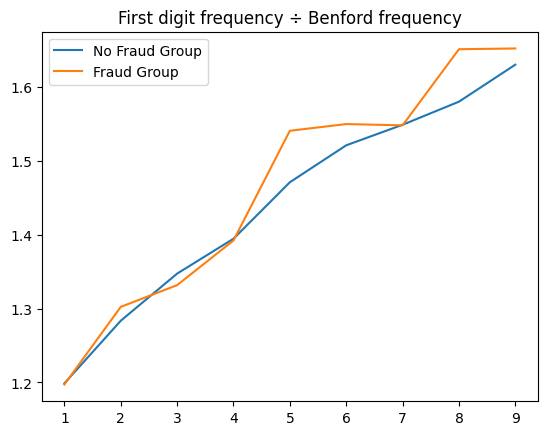

In [4]:
## Step 5. Put X and y together, and see the difference between y=0 group and y=1 group
X_y = pd.concat([X, y], axis=1)
print(X_y)
No_Fraud_Group = X_y[X_y['y']==0]
Fraud_Group = X_y[X_y['y']==1]
No_Fraud_Group_Frequency = []
Fraud_Group_Frequency = []
for i in range(9):
    No_Fraud_Group_Frequency.append(No_Fraud_Group.iloc[:,i].mean())
    Fraud_Group_Frequency.append(Fraud_Group.iloc[:,i].mean())
plt.plot([1,2,3,4,5,6,7,8,9],No_Fraud_Group_Frequency,label='No Fraud Group')
plt.plot([1,2,3,4,5,6,7,8,9],Fraud_Group_Frequency,label='Fraud Group')
plt.legend()
plt.title('First digit frequency ÷ Benford frequency')
plt.show()
y = y.values.ravel()

In [5]:
## Step 6. Split into train set and test set
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state = random_seed, stratify=y)

> A big issue is that the dataset is imbalanced, there are too few samples with y= 0.
>
> So within the trainning set we use *RandomUnderSampler:

In [6]:
## Step 7. Use RandomUnderSampler, because the dataset is very imbalanced
print("Before RandomUnderSampler, %s/%s=%s%% samples are y=1." % (np.sum(y_train==1),len(y_train),int(np.mean(y_train)*100)))
rus = RandomUnderSampler(sampling_strategy=1,random_state=random_seed)
x_new, y_new = rus.fit_resample(X_train, y_train)
X_train = x_new
y_train = y_new
print("After RandomUnderSampler, %s/%s=%s%% samples are y=1." % (np.sum(y_train==1),len(y_train),int(np.mean(y_train)*100)))

Before RandomUnderSampler, 36/279=12% samples are y=1.
After RandomUnderSampler, 36/72=50% samples are y=1.


[0.28133976 0.17009253 0.13187059 0.12136974 0.09911254 0.07945518
 0.06623627 0.03462594 0.01589746]


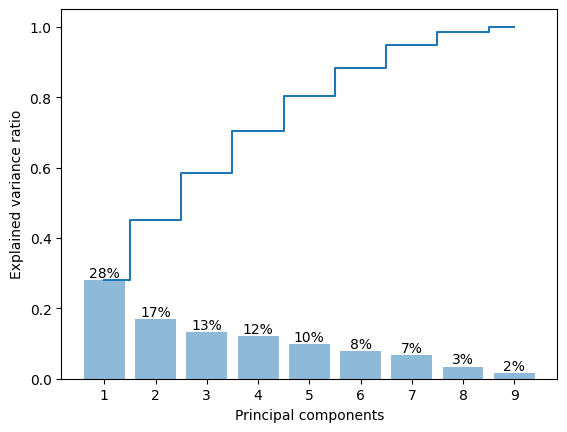

In [7]:
## Step 8. PCA feature engineering
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
pca.explained_variance_ratio_
print(pca.explained_variance_ratio_)
plt.bar(range(1, 10), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 10), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xticks(ticks=list(range(1,10)))
for i in range(1,10):
    plt.text(i, pca.explained_variance_ratio_[i-1], "{:.0%}".format(pca.explained_variance_ratio_[i-1]),fontsize=10,verticalalignment='bottom',horizontalalignment='center')
plt.show()
# Select features
X_train = X_train.iloc[:,:9]
X_test = X_test.iloc[:,:9]

## 5. Model Results

> Our task is to tell whether there is financial fraud, so we care about two index: 
> - 1) recall
>
> - 2) auc

> Logistic Regression and SVM get the best result, while Decision Tress gives the worst result:


|  | Logistic Regression | MLPClassfier | SVM | Decision Tree | Random Forest |
| :---: | :---: | :---: | :---: | :---: | :---: |
| Recall | 69% | 62% | 69% | 44% | 62% |
| AUC | 63% | 62% | 63% | 56% | 63% |


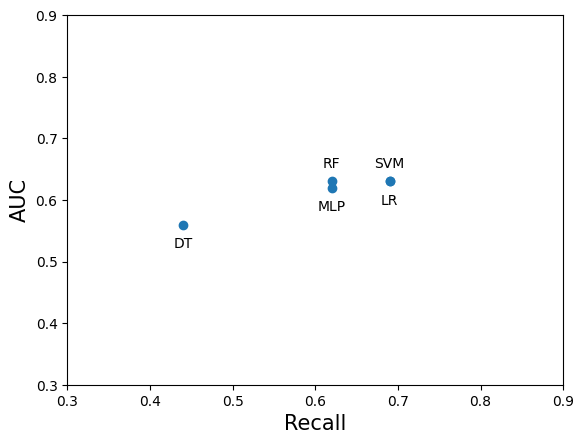

In [8]:
Recall_list = [0.69,0.62,0.69,0.44,0.62]
AUC_list = [0.63,0.62,0.63,0.56,0.63]
Method_list = ["LR","MLP","SVM","DT","RF"]
plt.scatter(Recall_list,AUC_list)
plt.xlim(0.3,0.9)
plt.ylim(0.3,0.9)
plt.xlabel('Recall', fontsize=15)
plt.ylabel('AUC', fontsize=15)
for i in range(5):
    if i not in [2,4]:
        plt.text(Recall_list[i],AUC_list[i]-0.02,Method_list[i], fontsize=10,horizontalalignment='center', verticalalignment='top')
    else:
        plt.text(Recall_list[i],AUC_list[i]+0.04,Method_list[i], fontsize=10,horizontalalignment='center', verticalalignment='top')
plt.show()

In [9]:
## Step 9. For each model, we define a function to evaluate the result for test set
def show_result(y_true, y_predict, y_predict_prob):
    # Confusion matrix
    matrix_test = confusion_matrix(y_true, y_predict)
    print("Confusion matrix:")
    print(matrix_test)
    # Classification report
    report_test = classification_report(y_true, y_predict)
    print("Classification report:")
    print(report_test)
    fpr,tpr,thresholds1 = roc_curve(y_true,y_predict_prob,drop_intermediate = False)
    # AUC score
    print("AUC score:")
    print(roc_auc_score(y_true,y_predict_prob))
    # ROC curve
    plt.plot(fpr,tpr,'r*-')
    plt.plot([0,1],[0,1])
    plt.plot("FPR")
    plt.plot("TPR")
    plt.title("ROC Curve")
    plt.plot(fpr,tpr,'r*-')
    plt.plot([0,1],[0,1])
    plt.plot("FPR")
    plt.plot("TPR")
    plt.title("ROC Curve")
    plt.show()

## 5.1 Logistic Regression

Grid Search for best model {'C': 140, 'penalty': 'l1'}
Confusion matrix:
[[53 51]
 [ 5 11]]
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       104
           1       0.18      0.69      0.28        16

    accuracy                           0.53       120
   macro avg       0.55      0.60      0.47       120
weighted avg       0.82      0.53      0.60       120

AUC score:
0.6322115384615385


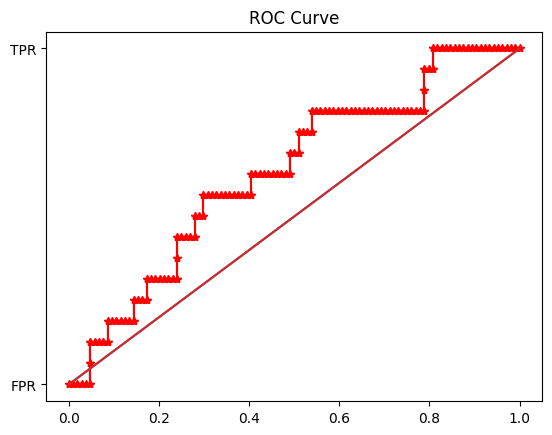

In [10]:
# Step 10.1 LogisticRegression
LR = LogisticRegression(solver='liblinear')
LR_param_grid = {
    'C': [10,20,50,75,100,110,120,130,140,150,160,170,180,190,200,250,500],
    'penalty': ['l1', 'l2'] }
LR_grid_search = GridSearchCV(LR, LR_param_grid, cv=5, return_train_score=True)
LR_grid_search.fit(X_train, y_train)
# Grid search result for hyperparameters
print("Grid Search for best model", LR_grid_search.best_params_)
LR_best_model = LR_grid_search.best_estimator_
y_LR_predict_prob_temp = LR_best_model.predict_proba(X_test)
y_LR_predict_prob = []
for i in range(len(y_LR_predict_prob_temp)):
    y_LR_predict_prob.append(y_LR_predict_prob_temp[i,1])
y_LR_predict = []
for i in range(len(y_LR_predict_prob)):
    if y_LR_predict_prob[i] > 0.5:
        y_LR_predict.append(1)
    else:
        y_LR_predict.append(0)
show_result(y_test, y_LR_predict, y_LR_predict_prob)

## 5.2 MLPClassifier

Grid Search for best model {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001, 'solver': 'adam'}
Confusion matrix:
[[51 53]
 [ 6 10]]
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.49      0.63       104
           1       0.16      0.62      0.25        16

    accuracy                           0.51       120
   macro avg       0.53      0.56      0.44       120
weighted avg       0.80      0.51      0.58       120

AUC score:
0.6219951923076923


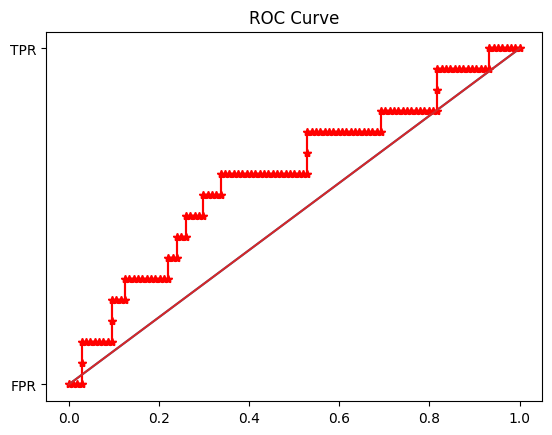

In [11]:
# # Step 10.2 MLP Classifier
MLP_grid = {
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'hidden_layer_sizes': [(10,10),(30,30),(80,80),(100,100),(120,120),(150,150)],
    'activation': ['tanh'], # ['logistic', 'tanh', 'relu'],
    'alpha': [0.0001],
    }
MLP_grid_search = GridSearchCV(MLPClassifier(max_iter = 300,random_state = random_seed), MLP_grid, cv=5, scoring='accuracy')
MLP_grid_search.fit(X_train, y_train)
# Grid search result for hyperparameters
print("Grid Search for best model", MLP_grid_search.best_params_)
MLP_best_model = MLP_grid_search.best_estimator_
y_MLP_predict_prob_temp = MLP_best_model.predict_proba(X_test)
y_MLP_predict_prob = []
for i in range(len(y_MLP_predict_prob_temp)):
    y_MLP_predict_prob.append(y_MLP_predict_prob_temp[i,1])
y_MLP_predict = []
for i in range(len(y_MLP_predict_prob)):
    if y_MLP_predict_prob[i] > 0.5:
        y_MLP_predict.append(1)
    else:
        y_MLP_predict.append(0)
show_result(y_test, y_MLP_predict, y_MLP_predict_prob)

## 5.3 SVM

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END .......C=500, gamma=10, kernel=rbf;, score=0.400 total time=   0.0s
[CV 2/5] END .......C=500, gamma=10, kernel=rbf;, score=0.533 total time=   0.0s
[CV 3/5] END .......C=500, gamma=10, kernel=rbf;, score=0.357 total time=   0.0s
[CV 4/5] END .......C=500, gamma=10, kernel=rbf;, score=0.429 total time=   0.0s
[CV 5/5] END .......C=500, gamma=10, kernel=rbf;, score=0.643 total time=   0.0s
[CV 1/5] END ......C=500, gamma=0.1, kernel=rbf;, score=0.600 total time=   0.0s
[CV 2/5] END ......C=500, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 3/5] END ......C=500, gamma=0.1, kernel=rbf;, score=0.643 total time=   0.0s
[CV 4/5] END ......C=500, gamma=0.1, kernel=rbf;, score=0.429 total time=   0.0s
[CV 5/5] END ......C=500, gamma=0.1, kernel=rbf;, score=0.714 total time=   0.0s
[CV 1/5] END .....C=500, gamma=0.03, kernel=rbf;, score=0.533 total time=   0.0s
[CV 2/5] END .....C=500, gamma=0.03, kernel=rbf

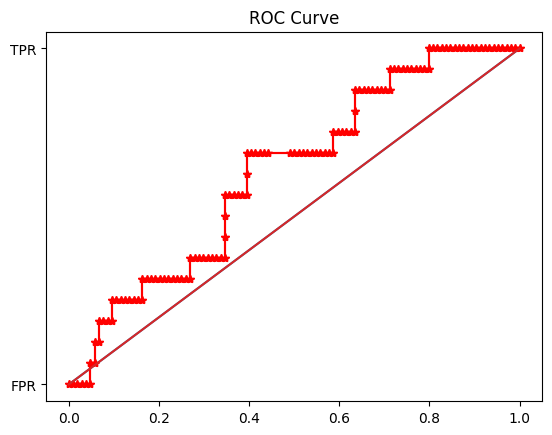

In [12]:
# Step 10.3 SVM
SVM_grid = {'C': [500,750,1000,1200,1500,1800,2000], 
	'gamma': [10, 0.1, 0.03, 0.01, 0.008, 0.005], 
	'kernel': ['rbf']} 
SVM_grid_search = GridSearchCV(SVC(probability=True), SVM_grid, refit = True, verbose = 3) 
SVM_grid_search.fit(X_train, y_train)
# Grid search result for hyperparameters
print("Grid Search for best model", SVM_grid_search.best_params_)
SVM_best_model = SVM_grid_search.best_estimator_
y_SVM_predict_prob_temp = SVM_best_model.predict_proba(X_test)
y_SVM_predict_prob = []
for i in range(len(y_SVM_predict_prob_temp)):
    y_SVM_predict_prob.append(y_SVM_predict_prob_temp[i,1])
y_SVM_predict = []
for i in range(len(y_SVM_predict_prob)):
    if y_SVM_predict_prob[i] > 0.5:
        y_SVM_predict.append(1)
    else:
        y_SVM_predict.append(0)
show_result(y_test, y_SVM_predict, y_SVM_predict_prob)

## 5.4 Decision Tree

Fitting 3 folds for each of 960 candidates, totalling 2880 fits
Grid Search for best model {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 2, 'min_samples_split': 2}
Confusion matrix:
[[72 32]
 [ 9  7]]
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       104
           1       0.18      0.44      0.25        16

    accuracy                           0.66       120
   macro avg       0.53      0.56      0.52       120
weighted avg       0.79      0.66      0.71       120

AUC score:
0.5649038461538461


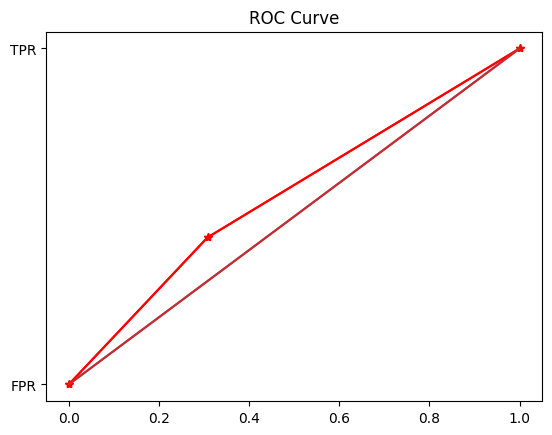

In [13]:
# Step 10.4 Decision tree
DT_grid = {'max_depth': [2,4,6,8,10],
    'max_leaf_nodes': list(range(2, 10)),
    'min_samples_split': list(range(2, 10)),
    'min_samples_leaf': [2,3,4]
    }
DT_grid_search = GridSearchCV(DecisionTreeClassifier(random_state = random_seed), DT_grid, verbose=1, cv=3)
DT_grid_search.fit(X_train, y_train)
# Grid search result for hyperparameters
print("Grid Search for best model", DT_grid_search.best_params_)
DT_best_model = DT_grid_search.best_estimator_
y_DT_predict_prob_temp = DT_best_model.predict_proba(X_test)
y_DT_predict_prob = []
for i in range(len(y_DT_predict_prob_temp)):
    y_DT_predict_prob.append(y_DT_predict_prob_temp[i,1])
y_DT_predict = []
for i in range(len(y_DT_predict_prob)):
    if y_DT_predict_prob[i] > 0.5:
        y_DT_predict.append(1)
    else:
        y_DT_predict.append(0)
show_result(y_test, y_DT_predict, y_DT_predict_prob)

## 5.5 Random Forest

Grid Search for best model {'max_depth': 4, 'min_samples_split': 30, 'n_estimators': 1200}
Confusion matrix:
[[65 39]
 [ 6 10]]
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74       104
           1       0.20      0.62      0.31        16

    accuracy                           0.62       120
   macro avg       0.56      0.62      0.53       120
weighted avg       0.82      0.62      0.68       120

AUC score:
0.6274038461538461


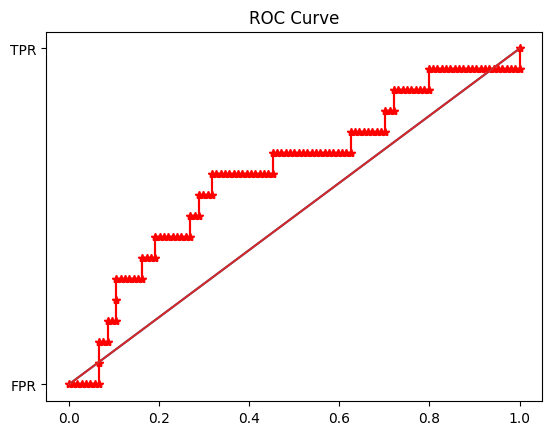

In [14]:
# Step 10.5 Random forest
RF_grid = {"n_estimators":[800,1000,1200],
    'max_depth':[4,5,6],
    "min_samples_split":[25,30,35]
    }
RF_grid_search = GridSearchCV(RandomForestClassifier(),param_grid = RF_grid,cv=3,scoring='accuracy')
RF_grid_search.fit(X_train, y_train)
# Grid search result for hyperparameters
print("Grid Search for best model", RF_grid_search.best_params_)
RF_best_model = RF_grid_search.best_estimator_
y_RF_predict_prob_temp = RF_best_model.predict_proba(X_test)
y_RF_predict_prob = []
for i in range(len(y_RF_predict_prob_temp)):
    y_RF_predict_prob.append(y_RF_predict_prob_temp[i,1])
y_RF_predict = []
for i in range(len(y_RF_predict_prob)):
    if y_RF_predict_prob[i] > 0.5:
        y_RF_predict.append(1)
    else:
        y_RF_predict.append(0)
show_result(y_test, y_RF_predict, y_RF_predict_prob)